# Анализ бизнес показателей

## Описание проекта

Последние пару месяцев наше приложение Procrastinate Pro+, несмотря на огромные вложения в рекламу терпит убытки. Наша задача - разобраться в причинах и помочь компании выйти в плюс.
Для ответа на поставленный вопрос, нам были предоставлены данные о пользователях приложения с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период, 
- рекламные расходы.

Предварительный план решения:
1. Выполнить обзор данных;
2. Предобработать данные;
3. Написать функции для расчёта и визуализации конверсии, удержания, LTV, ROI;
4. Посмотреть, как расходуются средства, выделяемые на закупку рекламы;
5. Расчёт конверсии, удержания, LTV, ROI, CAC;
6. Выявить перечень проблем, приведший к убыткам приложения.

Структура предоставленных данных:
- Структура **visits_info_short.csv**:
    - *User Id* — уникальный идентификатор пользователя,
    - *Region* — страна пользователя,
    - *Device* — тип устройства пользователя,
    - *Channel* — идентификатор источника перехода,
    - *Session Start* — дата и время начала сессии,
    - *Session End* — дата и время окончания сессии.
- Структура **orders_info_short.csv**:
    - *User Id* — уникальный идентификатор пользователя,
    - *Event Dt* — дата и время покупки,
    - *Revenue* — сумма заказа.
- Структура **costs_info_short.csv**:
    - *dt* — дата проведения рекламной кампании,
    - *Channel* — идентификатор рекламного источника,
    - *costs* — расходы на эту кампанию.

## 1. Обзор данных

In [1]:
# Подключаем необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib as plt
from datetime import datetime, timedelta

In [2]:
# Считываем полученные данные:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# Посмотрим на содержание предоставленных датафреймов:
display(visits.head())
display(orders.head())
display(costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
# Проверим данные на наличие пропусков, а также на соответствие типов:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

In [5]:
# Проверим данные на аномальные значения:
display(visits.describe())
display(orders.describe())
display(costs.describe())

,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


### Краткий вывод по итогам секции:
- название колонок не соответствует стилю 'snake_case',
- тип данных в столбцах, содержащих информацию о времени события, не соответствует типу datetime;

## 2. Предобработка данных

### 2.1 Приведение названий столбцов к стилю 'snake_case'

In [6]:
visits = visits.rename(columns = {'User Id' : 'user_id',
                         'Region' : 'region',
                         'Device' : 'device',
                         'Channel' : 'channel',
                         'Session Start' : 'session_start',
                         'Session End' : 'session_end'})

orders = orders.rename(columns = {'User Id' : 'user_id',
                                  'Event Dt' : 'event_dt',
                                  'Revenue' : 'revenue'})

costs = costs.rename(columns = {'Channel' : 'channel'})

### 2.2 Обработка дубликатов

In [7]:
# Посчитаем количество полных дубликатов в каждом датафрейме:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

In [8]:
# Проверим данные на наличие неявных дубликатов:
display(costs['channel'].unique())
display(visits['device'].unique())
display(visits['region'].unique())
display(visits['channel'].unique())

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

### 2.3 Приведение данных к нужным типам:

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

### Краткий вывод по итогам секции:
- названия столбцов были приведены к стилю 'snake_case',
- в датафреймах отсутствуют как полные, так и неявные дубликаты,
- данные в стобцах, содержащих информацию о времени того или иного события, были приведены к типу datetime.

## 3. Исследовательский анализ данных

### 3.1 Определение функций для расчёта/визуализации конверсии, удержания, LTV, ROI

#### 3.1.1 Функция для создания пользовательских профилей

In [10]:
def get_profiles(visits,orders,costs,event_names=[]):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].to_numpy().astype('datetime64[M]')
    
    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] =  profiles['user_id'].isin(orders['user_id'].unique())
    
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### 3.1.2 Функция для расчета удержания

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### 3.1.3 Функция для расчета LTV и ROI

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 


#### 3.1.4 Функция для фильтрации (сглаживания) данных

In [14]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### 3.1.5 Функция для визуализации удержания

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.pyplot.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.pyplot.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.pyplot.legend()
    plt.pyplot.xlabel('Лайфтайм')
    plt.pyplot.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.pyplot.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.pyplot.legend()
    plt.pyplot.xlabel('Лайфтайм')
    plt.pyplot.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.pyplot.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.pyplot.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.pyplot.tight_layout()
    plt.pyplot.show() 

#### 3.1.6 Функция для визуализации конверсии

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.pyplot.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.pyplot.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.pyplot.legend()
    plt.pyplot.xlabel('Лайфтайм')
    plt.pyplot.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.pyplot.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.pyplot.xticks(rotation = 45)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.pyplot.tight_layout()
    plt.pyplot.show() 

#### 3.1.7 Функция для визуализации LTV и ROI

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.pyplot.figure(figsize=(17, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.pyplot.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.pyplot.legend()
    plt.pyplot.xlabel('Лайфтайм')
    plt.pyplot.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.pyplot.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.pyplot.xticks(rotation = 45)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.pyplot.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.pyplot.xticks(rotation = 45)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.pyplot.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.pyplot.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.pyplot.legend()
    plt.pyplot.xlabel('Лайфтайм')
    plt.pyplot.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.pyplot.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.pyplot.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.pyplot.xticks(rotation = 45)
    plt.pyplot.xlabel('Дата привлечения')
    plt.pyplot.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.pyplot.tight_layout()
    plt.pyplot.show() 

### 3.2 Составление профилей пользователей

In [18]:
# Вызовем функцию, агрегирующую данные о пользователях в один датафрейм:
profiles = get_profiles(visits, orders, costs)

In [19]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
# Определим минимальную и максимальную даты привлечения пользователей:
print("Минимальный таймстемп привлечения: {}".format(profiles['first_ts'].min()))
print("Максимальный таймстемп привлечения: {}".format(profiles['first_ts'].max()))

Минимальный таймстемп привлечения: 2019-05-01 00:00:41
Максимальный таймстемп привлечения: 2019-10-27 23:59:04


In [21]:
# Инициализируем функцию для расчёта количества уникальных и процента платящих пользователей, свойственных той или иной фиче
# из датафрейма с профилями пользователей. А также визуализирующей динамику привлечения пользователей для данной фичи: 
def profiles_group(profiles, groupby_parameter):
    profiles_grouped_by_region = profiles.groupby(groupby_parameter) \
    .agg({'user_id' : 'nunique', 'payer' : 'mean'}) \
    .sort_values(by = ['user_id', 'payer'], ascending = False) \
    .rename(columns = {'user_id' : 'unqiue_users_per_{}'.format(groupby_parameter),
                       'payer' : 'mean_amount_of_paying_users_per_{}, %'.format(groupby_parameter)})
    profiles_grouped_by_region['mean_amount_of_paying_users_per_{}, %'.format(groupby_parameter)] = \
    profiles_grouped_by_region['mean_amount_of_paying_users_per_{}, %'.format(groupby_parameter)] * 100
    total_unique_users = profiles_grouped_by_region['unqiue_users_per_{}'.format(groupby_parameter)].sum()
    profiles_grouped_by_region['unique_to_total, %'] = profiles_grouped_by_region['unqiue_users_per_{}'.format(groupby_parameter)] \
        / total_unique_users * 100
    profiles_grouped_by_region = profiles_grouped_by_region[['unqiue_users_per_{}'.format(groupby_parameter),
                                                             'unique_to_total, %',
                                                             'mean_amount_of_paying_users_per_{}, %'.format(groupby_parameter)]] \
        .sort_values(by = ['unqiue_users_per_{}'.format(groupby_parameter), 'mean_amount_of_paying_users_per_{}, %'.format(groupby_parameter)], ascending = False)
    display(profiles_grouped_by_region)
    
    profiles.pivot_table(
        index = 'month',
        columns = groupby_parameter,
        values = 'user_id',
        aggfunc = 'nunique').plot(grid = True,
                                  figsize  = (15, 4),
                                  title = 'dynamics of attracting users from different {}s'.format(groupby_parameter))

,unqiue_users_per_region,"unique_to_total, %","mean_amount_of_paying_users_per_region, %"
region,,,
United States,100002,66.664445,6.901862
UK,17575,11.716042,3.982930
France,17450,11.632713,3.799427
Germany,14981,9.986801,4.111875


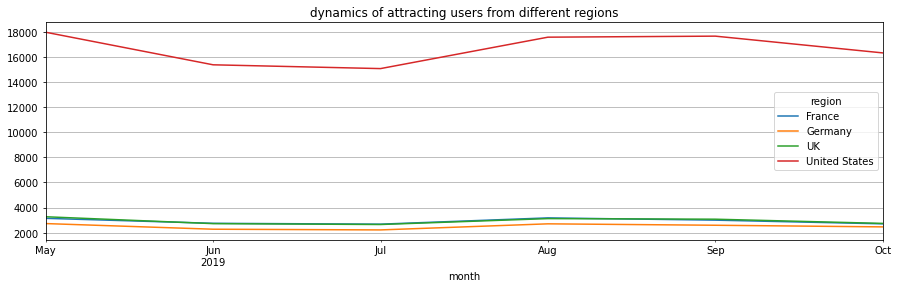

In [22]:
# Посмотим, из каких стран приходят новые пользователи, а также определим страны,
# "поставляющие" самых платежеспособных пользователей:
profiles_group(profiles, 'region')

- Страны, из которых наши клиенты пользуются нашим приложением:
    - США,
    - Великобритания,
    - Германия,
    - Франция.
- Больше всего пользователей привлекается в приложение из США (порядка 2/3), второе место делят между собой Франция и Великобритания (порядка 12% на каждую), последнее место с небольшим отставанием занимает Германия (примерно 10%).
- Наиболее платёжеспособных пользователей поставляют США (6.9%), следом идут Германия(4.11%), Великобритания(3.98%) и Франция(3.8%).
- Динамика привлечения пользователей из разных стран имеет стабильную зависимость, также присутствует небольшая сезонность.

,unqiue_users_per_device,"unique_to_total, %","mean_amount_of_paying_users_per_device, %"
device,,,
iPhone,54479,36.317396,6.207897
Android,35032,23.353421,5.851793
PC,30455,20.302251,5.046790
Mac,30042,20.026932,6.364423


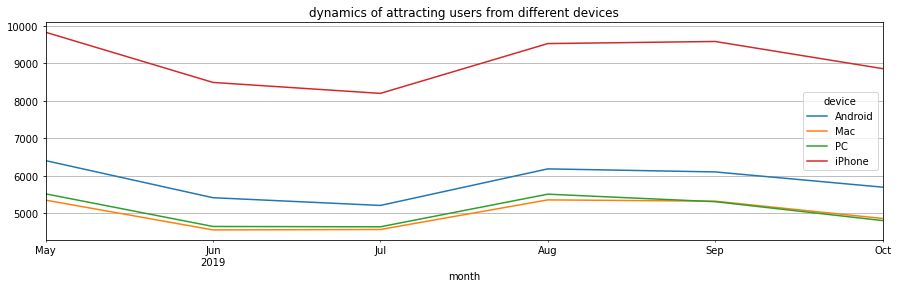

In [23]:
# Посмотим, с каких устройств приходят новые пользователи, а также определим устройства,
# "поставляющие" самых платежеспособных пользователей:
profiles_group(profiles, 'device')

- Наибольшее количество пользователей пользуются нашим приложением с айфона (примерно 36%), следующими по популярности идёт андроид (23%), последнее место занимают PC и MAC (примерно 20%).
- Самые платежеспособные пользователи пользуются MAC (6.4%), остальные устройтва обладают следующей популярностью: айфон (6.2%), андроид (5.9%) и PC (5%).
- Характер динамики привлечения пользователей с разных платформ носит похожий характер на динамику привлечения пользователей из разных стран. Тренд в целом стабилен, хоть и присутствует чуть большая сезонность.

,unqiue_users_per_channel,"unique_to_total, %","mean_amount_of_paying_users_per_channel, %"
channel,,,
organic,56439,37.623993,2.055316
FaceBoom,29144,19.428297,12.204914
TipTop,19561,13.039971,9.600736
OppleCreativeMedia,8605,5.736361,2.707728
WahooNetBanner,8553,5.701696,5.296387
LeapBob,8553,5.701696,3.063253
RocketSuperAds,4448,2.965175,7.913669
MediaTornado,4364,2.909178,3.574702
YRabbit,4312,2.874513,3.826531


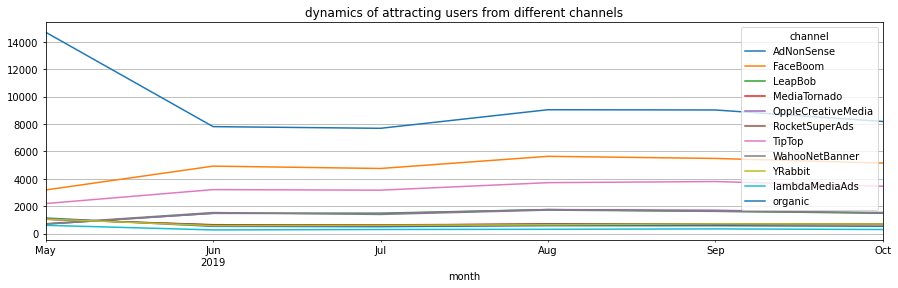

In [24]:
# Посмотим, из каких источников привлечения приходят новые пользователи, а также 
# определим источники привелечения,"поставляющие" самых платежеспособных пользователей:
profiles_group(profiles, 'channel')

- Всего наши пользователи привлекаются из 11 каналов привлечения.
- Больше всего пользователей привлекаются в приложение из канала 'organic', то есть большая часть пользователей самостоятельно находят  продукт.
- Если не учитывать органических пользователей, то больше всего клиентов привлекается из каналов 'FaceBoom' и 'Tiptop', причем каждый из этих каналов поставляет в три-четыре раза больще пользователей, нежели любой другой канал привлечения.
- Одновременно с этим каналы 'FaceBoom' и 'Tiptop' поставляют одних из самых платёжеспособных пользователей.
- Пользователи, самостоятельно пришедшие в приложение обладают самой низкой платежеспособностью.

### 3.3 Анализ Маркетинга

#### 3.3.1 Расчет общей суммы расходов на маркетинг

In [25]:
# Для того чтобы проверить, правильно ли были сформированы профили пользователей, посчитаем
# расходы на маркетинг двумя способами, по сырым и уже сгруппированным данным:
print("Расходы на маркетинг по сырым данным составляет: {}".format(costs['costs'].sum()))
print("Расходы на маркетинг по агрегированным данным составляет: {}".format(profiles['acquisition_cost'].sum()))

Расходы на маркетинг по сырым данным составляет: 105497.30000000002
Расходы на маркетинг по агрегированным данным составляет: 105497.29999999999


#### 3.3.2 Сколько денег потратили на каждый источник?

In [26]:
# Посмотрим, как траты распределены по рекламным источникам:
channel_top = (profiles.groupby('channel')
               .agg({'acquisition_cost': 'sum'}) \
               .sort_values(by = 'acquisition_cost', ascending = False)
)
channel_top_sum = channel_top['acquisition_cost'].sum()
channel_top['acquisition_cost_to_total, %'] = channel_top['acquisition_cost'] / channel_top_sum * 100
channel_top

,acquisition_cost,"acquisition_cost_to_total, %"
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


- Более 80% рекламного бюджета выделяется на каналы 'TipTop' (52%) и 'FaceBoom' (31%). 

#### 3.3.3 Как менялась динамика расходов рекламного бюджета во времени?

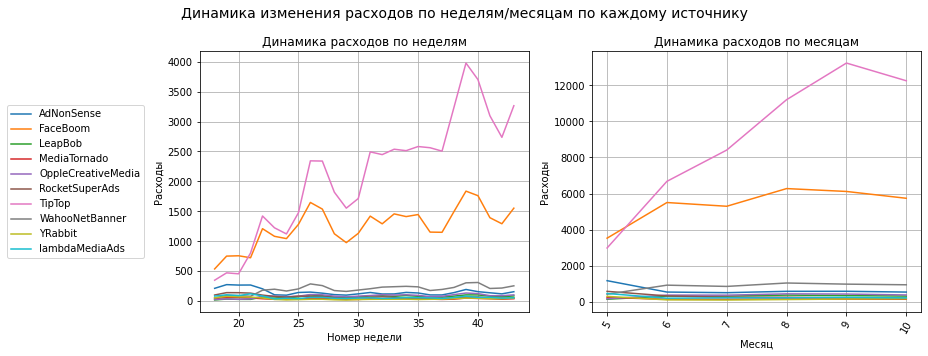

In [27]:
# Посмотрим, как менялась динамика расходов рекламного бюджета в разбивке по каналам привлечения:
#costs['month'] = pd.to_datetime(costs['dt']).dt.strftime('%b-%Y')
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
plt.pyplot.figure(figsize=(16, 5)).suptitle('Динамика изменения расходов по неделям/месяцам по каждому источнику',
                                            fontsize = 14);

ax_1 = plt.pyplot.subplot(1, 2, 1)
costs.pivot_table(index = 'week',
                  columns = 'channel',
                  values='costs',
                  aggfunc='sum').plot(ax = ax_1,
                                     figsize = (13, 5),
                                     grid = True)
ax_1.legend(ncol = 1, loc = 'center left', bbox_to_anchor = (-0.6, 0.5))

plt.pyplot.title('Динамика расходов по неделям', fontsize = 12)
plt.pyplot.xlabel('Номер недели', fontsize = 10)
plt.pyplot.ylabel('Расходы', fontsize = 10)

ax_2 = plt.pyplot.subplot(1, 2, 2)
costs.pivot_table(index = 'month',
                  columns = 'channel',
                  values='costs',
                  aggfunc='sum').plot(ax = ax_2,
                                     figsize = (13 , 5),
                                     grid = True,
                                     legend = False,
                                     rot = 60)
plt.pyplot.title('Динамика расходов по месяцам', fontsize = 12)
plt.pyplot.xlabel('Месяц', fontsize = 10)
plt.pyplot.ylabel('Расходы', fontsize = 10)

plt.pyplot.tight_layout()

- Рекламный бюджет в течение последнего полугода планомерно увеличивался от месяца к месяцу.
- Количество денежных средств, выделяемых на привлечение пользователей из всех каналов кроме 'FaceBoom' и 'TipTop', практически не менялось за весь горизонт событий.
- Начиная с мая отдел маркетинга начал делать ставку на рекламу в каналах 'Faceboom' и 'TipTop', с тех пор мы видим поступательный рост расходов рекламного бюджета, выделяемого на привлечение пользователей из этих каналов.

#### 3.3.4 Сколько стоит привлечение одного пользователя из каждого источника?  Расчет CAC.

In [28]:
cac_per_channel = profiles.query('channel != "organic"').groupby('channel') \
                                      .agg({'acquisition_cost' : 'mean'}) \
                                      .sort_values(by = 'acquisition_cost',
                                                   ascending = False) \
                                      .rename(columns = {'acquisition_cost' : 'CAC_per_channel'})
cac_per_channel['mean_cac'] = profiles.query('channel != "organic"')['acquisition_cost'].mean()
cac_per_channel

,CAC_per_channel,mean_cac
channel,,
TipTop,2.799003,1.127481
FaceBoom,1.113286,1.127481
AdNonSense,1.008054,1.127481
lambdaMediaAds,0.724802,1.127481
WahooNetBanner,0.602245,1.127481
RocketSuperAds,0.412095,1.127481
OppleCreativeMedia,0.250000,1.127481
YRabbit,0.218975,1.127481
MediaTornado,0.218717,1.127481


In [29]:
profiles.query('channel != "organic"')['acquisition_cost'].mean()

1.1274813239427588

- Каналы 'Tiptop' и 'FaceBoom', 'AdNoNSense' обладают самой большой стоимостью привлечения одного нового пользователя, 2.8%, 1.1% и 1% соответственно.
- Каналы 'OppleCreativeMedia', 'YRabbit', 'MediaTornado' и 'LeapBob'обладают самой низкой стоимостью привлечения нового пользователя, 0.25%, 0.22%, 0.22% и 0.21% соответственно. 

### 3.4 Оценка окупаемости рекламы

#### 3.4.1 Анализ окупаемости с помощью графиков динамики LTV,  ROI, CAC

In [30]:
# Выставим момент анализа и горизонт анализа:
observation_date = datetime(2019, 10, 1).date()
horizon_days = 14

In [31]:
# Отсеем пользователей, которые сами нашли наше приложение:
profiles = profiles.query('channel != "organic"')

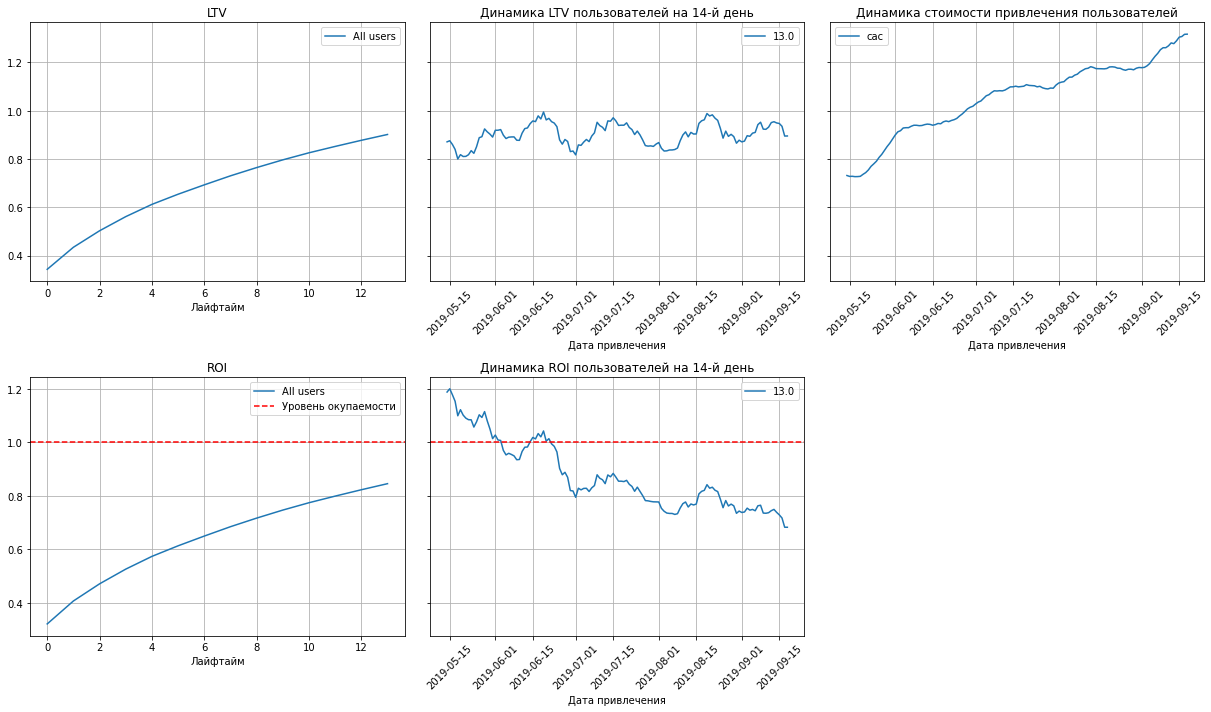

In [32]:
# Смотрим на состояние и динамику LTV, ROI, CAC без группировки.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- Реклама не окупается, тк к концу второй недели горизонта анализа ROI не достигает уровня окупаемости.
- Стоимость привлечения новых пользователей постоянно растёт, при этом ROI постепенно снижается. Неудивительно, что реклама не окупает себя.
- LTV подвержен сезонности, но в долгосрочной перспективе стабилен.

#### 3.4.2 Анализ конверсии и удержания, а также их поведения в динамике

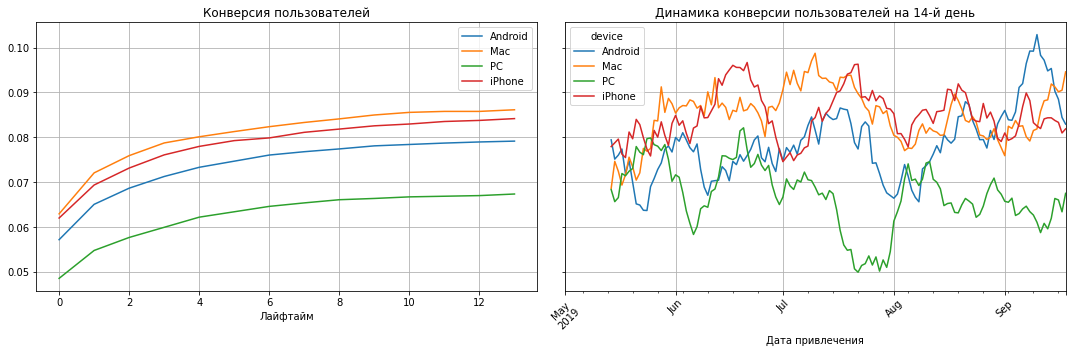

In [33]:
# Конверсия в разбивке по девайсам:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['device']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия в разбивке по девайсам:
- Наибольшая конверсия свойственна пользователям, которые пользуются Mac и iPhone.
- Хуже всего конвертируются пользователи, которые пользуются PC.
- Пользователи конвертируются стабильно на протяжении всего горизонта анализа.
- Конверсия пользователя на 14 день характеризуется значимыми сезонными колебаниями, но так или иначе можно сказать, что её поведение можно считай достаточно стабильным (в долгострочной перспективе).

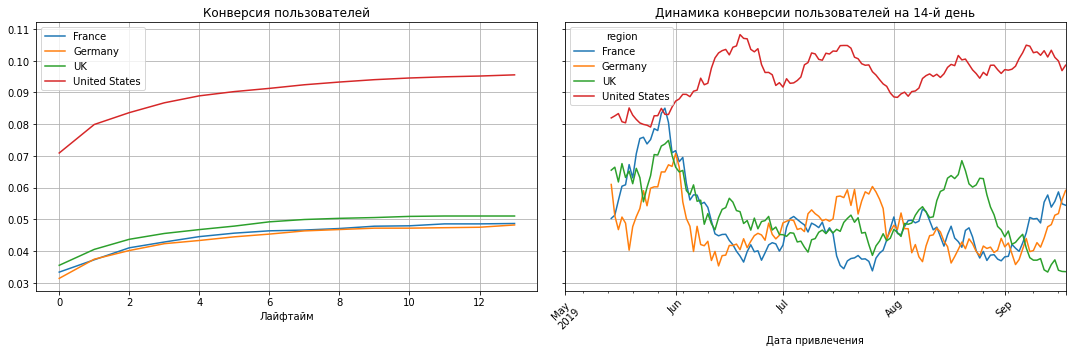

In [34]:
# Конверсия в разбивке по странам:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['region']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия в разбивке по странам:
- Наибольшая конверсия свойственна пользователям из США.
- Конверсия пользователей из Франции, Великобритании и Германии практически идентична.
- Пользователи из США конвертируются стабильно на протяжении всего горизонта анализа.
- Конверсия пользователей из Франции, Великобританнии, Германии незначительно снижается на протяжении горизонта анализа. 

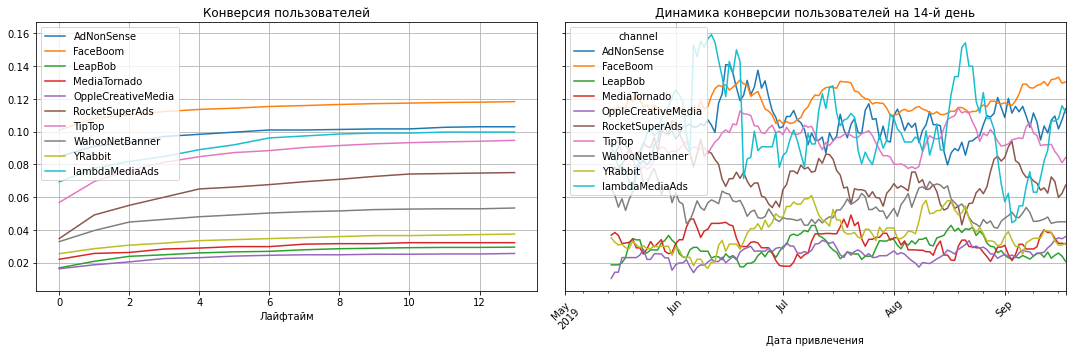

In [35]:
# Конверсия в разбивке по каналам:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия в разбивке по каналам:
- Наибольшая конверсия свойственна пользователям, привлеченным по каналам 'FaceBoom', 'AdNonSense', 'lambdaMediaAds'.
- Хуже всего конвертируются пользователи из каналов 'OppleCreativeMeadia', 'LeapBob', 'MediaTornado', 'YRabbit'.
- Конверсия пользователя на 14 день характеризуется значимыми сезонными колебаниями, но так или иначе можно сказать, что её поведение можно считай достаточно стабильным (в долгострочной перспективе).

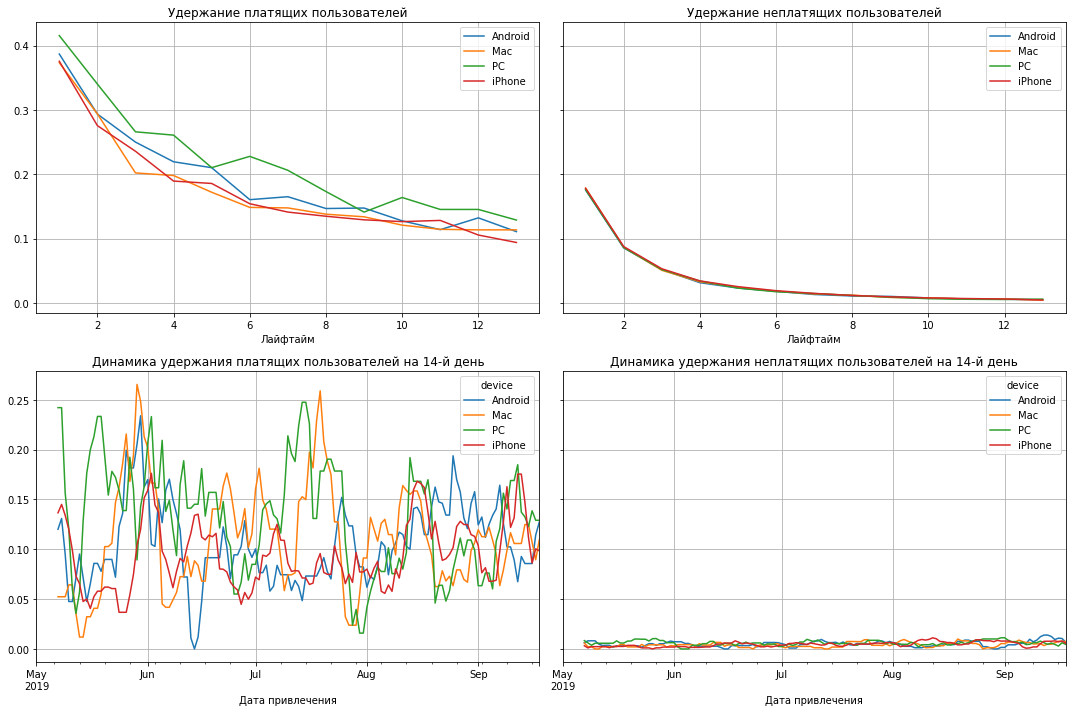

In [36]:
# Удержание в разбивке по девайсам:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Вывод по удержанию в разбивке по платформам:
- Наибольшим удержанием характеризуются клиенты, пользующиеся PC, Android.
- Хуже удерживаются клиенты, пользующиеся iPhone и Mac.
- Динамика удержания характеризуется сезонностью, несмотря на что её можно считать достаточно стабильной в долгосрочной перспективе.

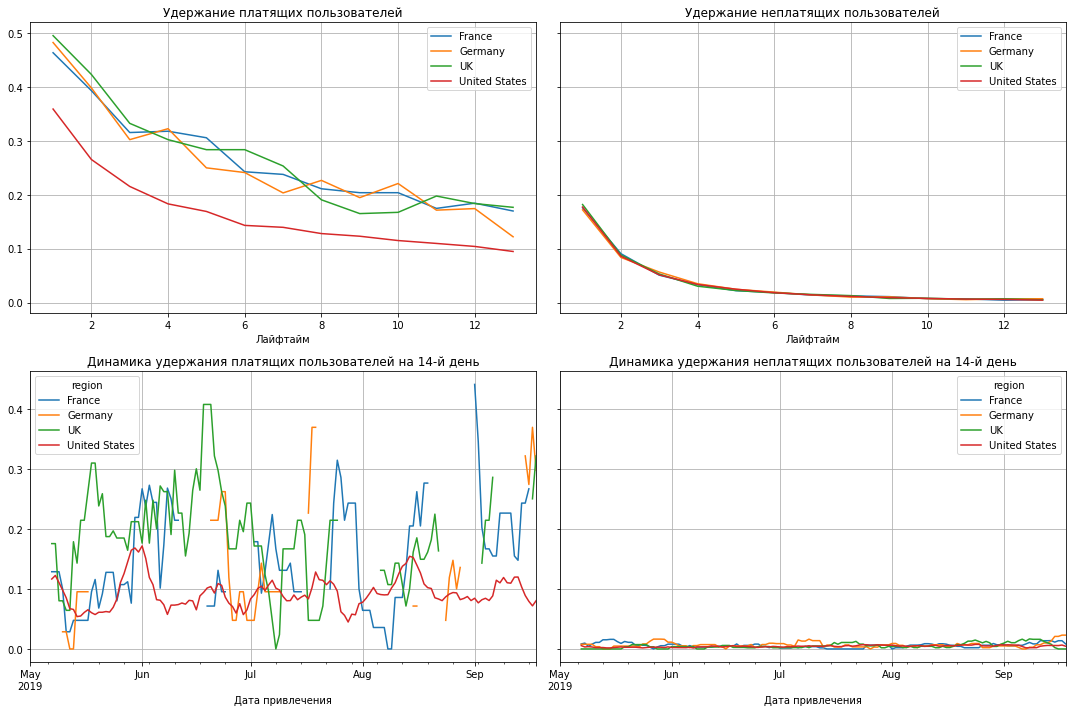

In [37]:
# Удержание в разбивке по регионам:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Вывод по удержанию в разбивке по странам:
- Пользователи из США значительно хуже удерживаются по сравнению с пользователями из других стран.
- Динамика удержания характеризуется сезонностью, несмотря на что её можно считать достаточно стабильной в долгосрочной перспективе.

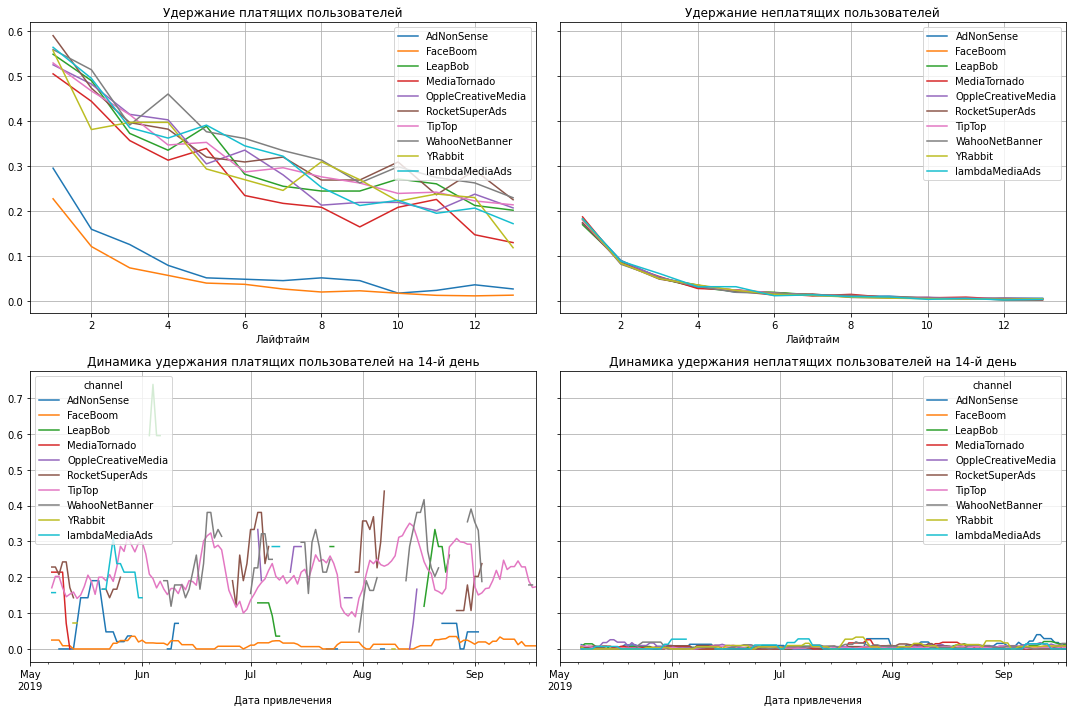

In [38]:
# Удержание в разбивке по каналам:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Вывод по удержанию в разбивке по каналам:
- Клиенты, привлеченные по каналам 'AdNonSense', 'FaceBoom', характеризуются очень низким удержанием по сравнению с клиентами, привлеченными по другим каналам.

#### 3.4.3 Анализ окупаемости с разбивкой по устройствам.

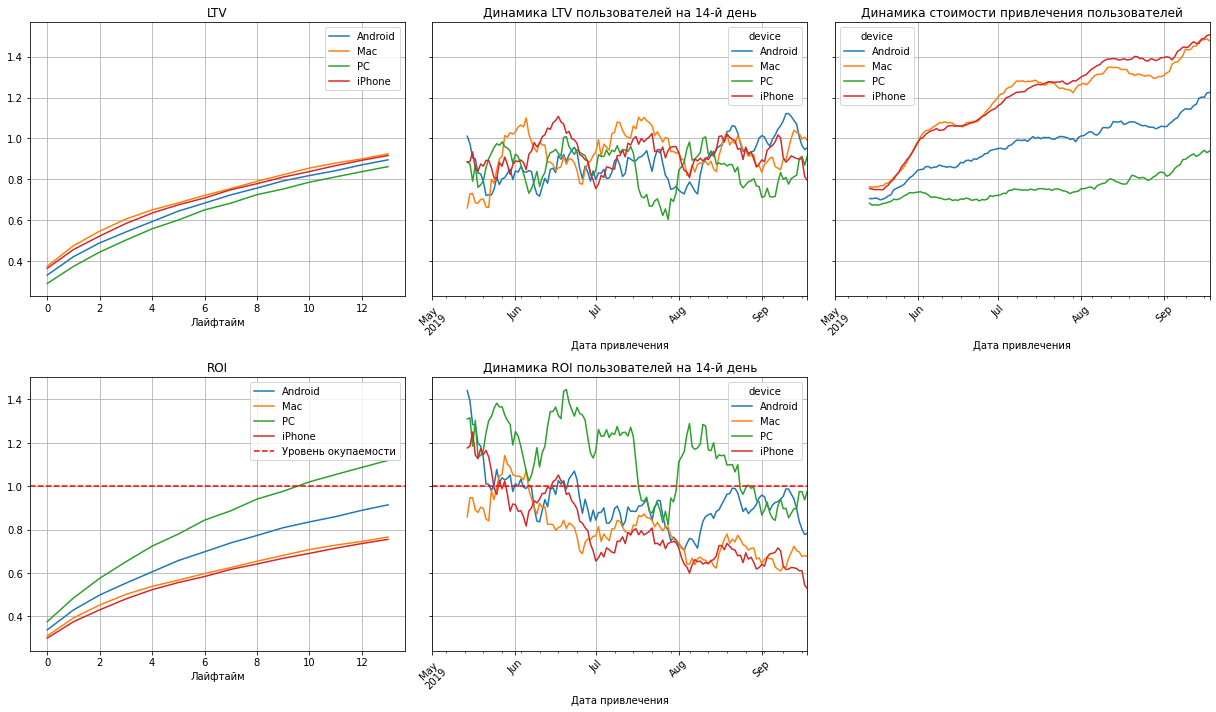

In [39]:
# Анализ окупаемости в разбивке по девайсам:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализ окупаемости в разбивке по девайсам:
- Динамика стоимости привлечения новых пользователей растет по всем устройствам, больше всего для Mac и iPhone. Стоимость привлечения пользователя на PC растёт медленней всего и не так быстро.
- Реклама окупается только для пользователей PC, причём достаточно стабильно, хоть и наблюдается её снижение.
- LTV стабилен.

#### 3.4.4 Анализ окупаемости с разбивкой по странам.

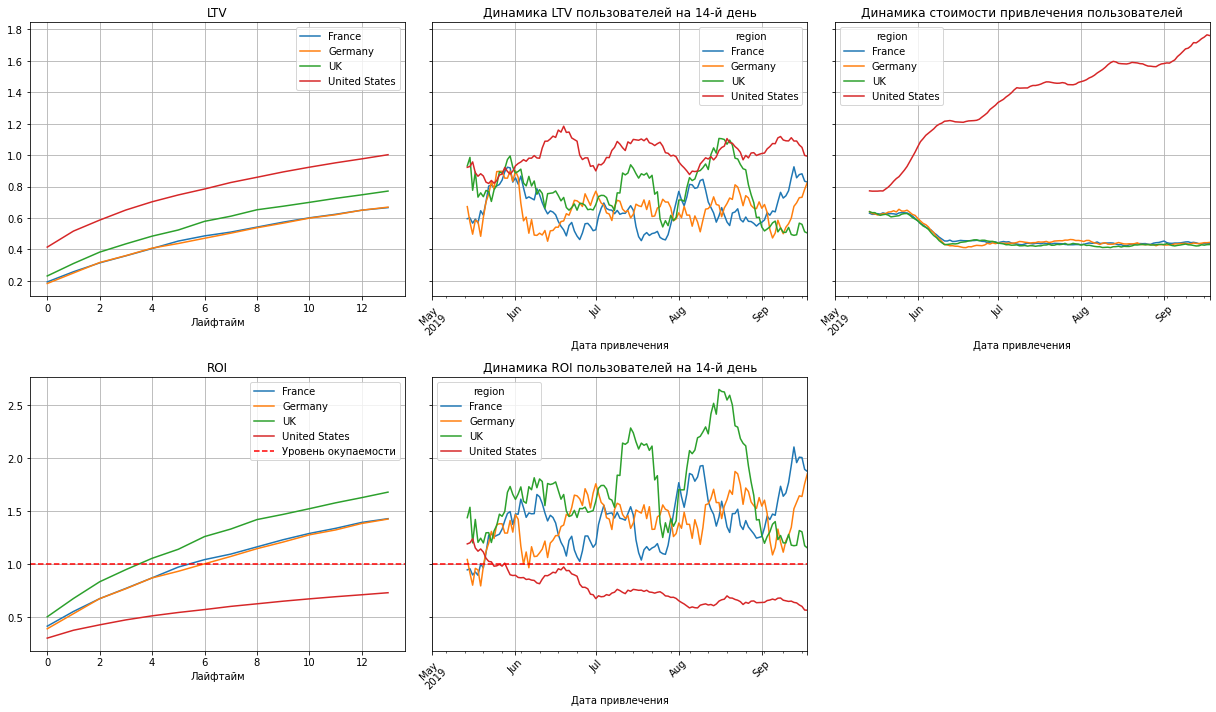

In [40]:
# Анализ окупаемости в разбивке по странам:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализ окупаемости в разбивке по странам:
- Все страны кроме США окупаются, ROI для США едва достигает 80%.
- С конца мая стоимость привлечения пользователей из США стала стремительно расти, с учетом того, что 66% наших клиентов из США, это интересное наблюдение.
- LTV стабилен, в США он больше чем в других странах.

#### 3.4.5 Анализ окупаемости с разбивкой по каналам.

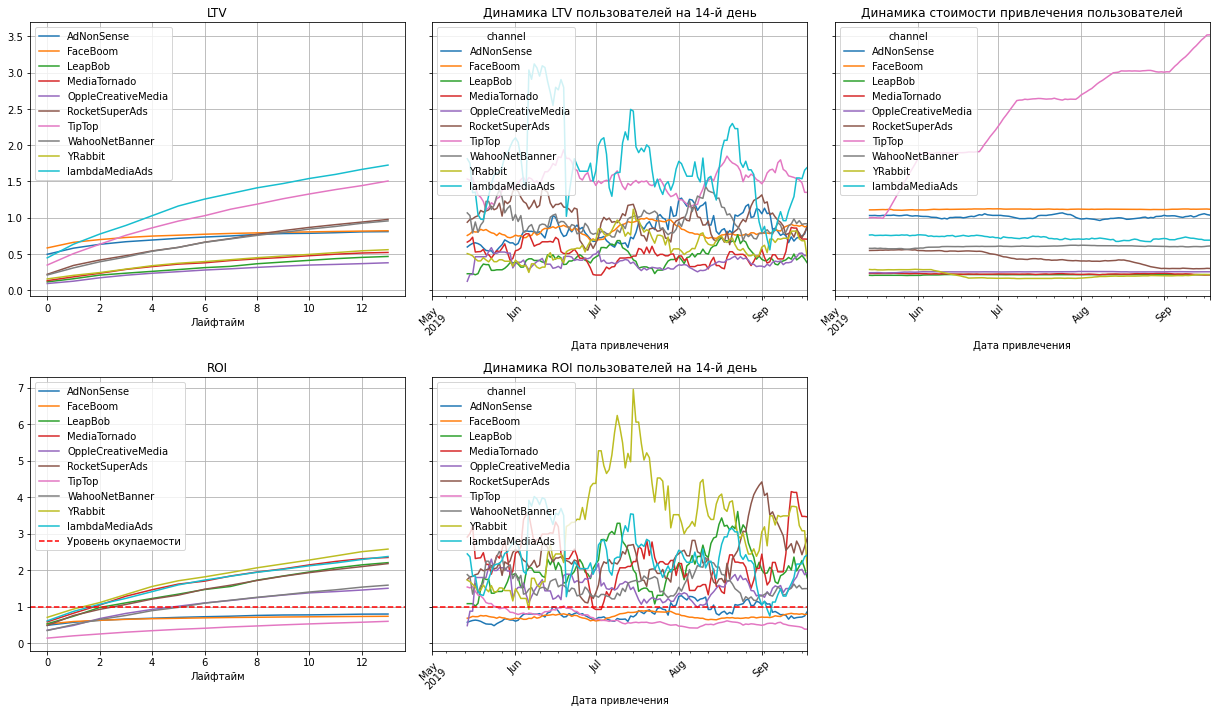

In [41]:
# Анализ окупаемости в разбивке по каналам:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализ окупаемости в разбивке по каналам:
- Каналы AdNonSense, FaceBoom, TipTop не окупаются.
- Стоимость привлечения по каналу TipTop с конца мая начала стремительно расти от месяца к месяцу.
- Лучше всего окупаются YRabbit, MediaTornado и lambdaMediaAds

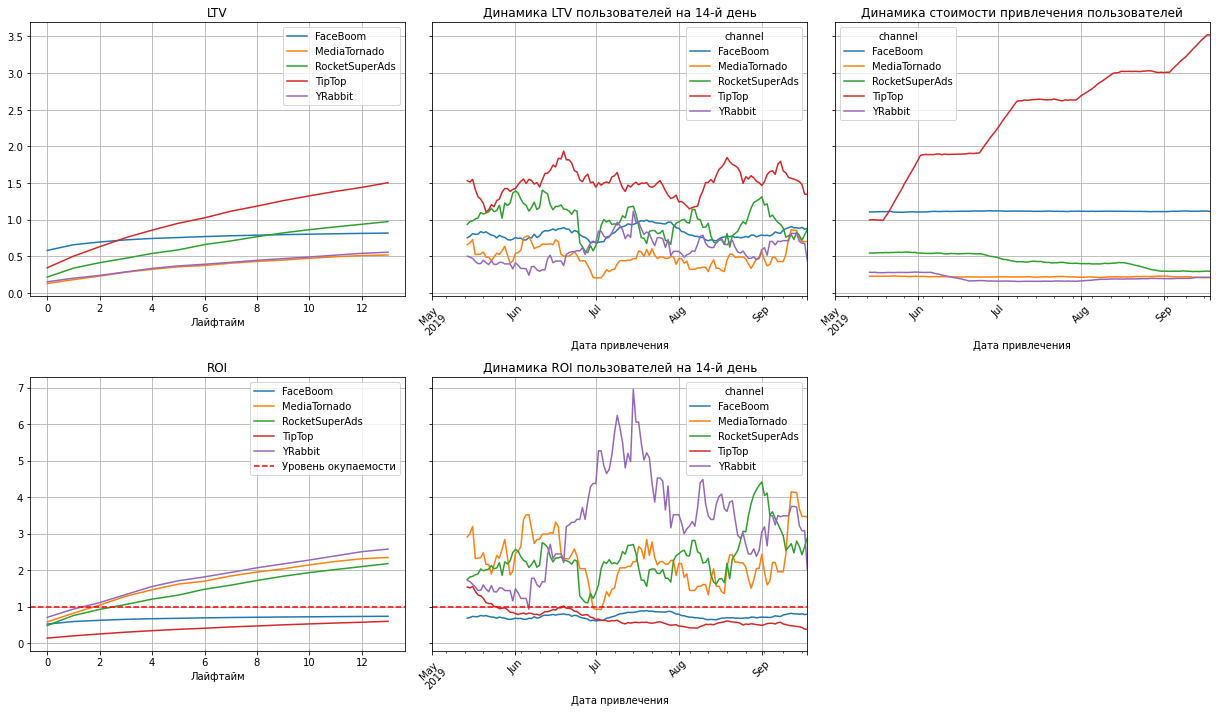

In [42]:
# Проведем анализ окупаемости с разбивкой по каналам для США:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализ окупаемости с разбивкой по каналам для США:
- Каналы 'FaceBoom', 'Tiptop' не оккупаются в США.
- Стоимость привлечения по каналу TipTop с конца мая начала стремительно расти от месяца к месяцу. Тем самым, начиная с середины мая, он перестал себя окупать.
- Летом в США прошла супер успешная рекламная компания в партнерстве с каналом 'YRabbit', что можно наблюдать на визуализации динамики ROI. 

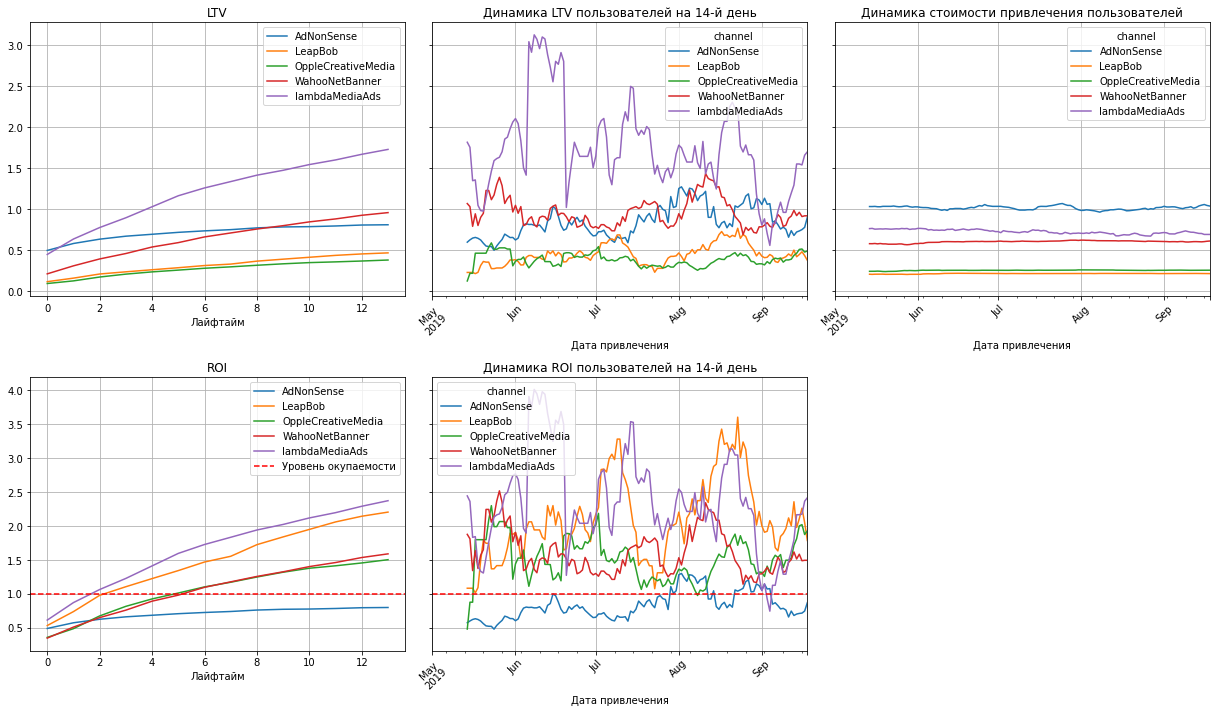

In [43]:
# Проведем анализ окупаемости с разбивкой по каналам для европейского рынка:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region != "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Проведем анализ окупаемости с разбивкой по каналам для европейского рынка:
- Канал 'AdNonSense' не окупается.
- Каналы 'lambdaMediaAds', 'LeapBob' окупаются очень хорошо.

### 4. Финальные выводы

Причины по которым приложение последние месяцы терпит убытки:
- С начала мая 2019 года отдел маркетинга при планировании рекламной компании решил сделать ставку на два канала привлечения новых пользователей: 'TipTop', 'FaceBoom', по итогу потратив на них более 80% рекламного бюджета. Однако данная стратегия не возымела должного успеха, тк данные каналы привлечения по итогу оказались убыточными:
    - 'TipTop' оказался убытычным из-за монотонного роста стоимости привлечения пользователя из этого канала.
    - 'FaceBoom' оказался убытычным из-за низкого удержания пользователей из этого канала (аналогичная ситуация с каналом AdNonSense).


Рекомендации для отдела маркетинга:
- Обратить более пристальное внимание на пользователей, которые пользуются PC, ведь рекламные средства, потраченные на них, стабильно себя отбивают.
- На европейского рынка стоит рассмотреть возможность снижения рекламных средств, выделяемых на неокупаемый канал привлечения 'AdNonSense'. Взамен стоит рассмотреть каналы, которые хорошо окупаются: 'lambdaMediaAds', 'LeapBob'.
- Для рынка США необходимо рассмотреть возможность снижения рекламных средств, выделяемых на неокупаемые каналы привлечения, а именно на 'FaceBoom', 'TipTop'. Взамен стоит переорентироваться на каналы, которые полностью себя окупают: 'YRabbit', 'RocketSuperADs', 'MedaiaTornado'. Особенно сильно стоит изучить возможность сотрудничества с каналом 'YRabbit', ведь летом их пользователи очень хорошо окупались.
- Стоит рассмотреть возможность перевести часть расходов на европейский рынок, ведь он полностью окупается.